In [ ]:
# !pip install quantstats
# !pip install optuna
# !pip install ta

# !sudo apt update
# !sudo apt install ttf-mscorefonts-installer
# !sudo apt install msttcorefonts -qq
# !sudo fc-cache -f -v


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def load_stock_data(file_path):
    # Φόρτωση του αρχείου CSV σε DataFrame
    df = pd.read_csv(file_path, parse_dates=['time'])

    # Αφαίρεση της στήλης 'complete'
    df.drop(columns=['complete'], inplace=True, errors='ignore')
    
    # Ορισμός της στήλης 'time' ως index
    df.set_index('time', inplace=True)
    
    # Μετονομασία των στηλών
    df.rename(columns={'volume': 'Volume', 'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close'}, inplace=True)
    
    return df

# def get_records_for_period(df, start_date, end_date):
#     """
#     Επιστρέφει το πλήθος εγγραφών για κάθε ημέρα εντός του δοσμένου διαστήματος.
#     """
#     period_data = df.loc[start_date:end_date]
#     records_per_day = period_data.resample('D').size()
#     return records_per_day.reset_index().rename(columns={'time': 'date', 0: 'count'})

def plot_records_distribution(df):
    """
    Δημιουργεί διάγραμμα συχνότητας των εγγραφών για το σύνολο των δεδομένων.
    """
    records_per_day = df.resample('D').size().reset_index()
    records_per_day.columns = ['date', 'count']
    plt.figure(figsize=(12, 6))
    bars = plt.bar(records_per_day['date'], records_per_day['count'], color='blue')
    plt.xlabel('Ημερομηνία')
    plt.ylabel('Πλήθος Εγγραφών')
    plt.title(f'Κατανομή Εγγραφών')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Εμφάνιση του αριθμού εγγραφών πάνω από κάθε μπάρα
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height,
            f'{int(height)}',
            ha='center', va='bottom',
            fontsize=12,      # Μεγαλύτερη γραμματοσειρά
            # rotation=90       # Περιστροφή κειμένου
        )

    plt.tight_layout()
    plt.show()

def plot_stock_prices(df):
    """
    Δημιουργεί διάγραμμα με τις τιμές των μετοχών (κλείσιμο) για το σύνολο του DataFrame.
    Προσθέτει σκίαση ανά ημέρα ή εβδομάδα.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index.to_numpy(), df['Close'].to_numpy(), color='green', linestyle='-', marker='o')
    
    # Προσθήκη σκίασης ανά ημέρα
    for i, date in enumerate(pd.date_range(start=df.index.min(), end=df.index.max())):
        if i % 2 == 0:
            ax.axvspan(date, date + pd.Timedelta(days=1), color='gray', alpha=0.2)
    
    ax.set_xlabel('Ημερομηνία')
    ax.set_ylabel('Τιμή Κλεισίματος')
    ax.set_title(f'Τιμές Κλεισίματος')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
        
def get_stock_data_for_period(df, start_date, end_date, frequency):
    """
    Επιστρέφει τις τιμές των μετοχών για το δοσμένο χρονικό διάστημα με ανάλυση δείγματος σε λεπτά.
    Αν frequency = 0, επιστρέφει τα αρχικά δεδομένα χωρίς δειγματοληψία.
    Αν υπάρχουν άλματα στις ημερομηνίες, ενσωματώνει την πλησιέστερη διαθέσιμη εγγραφή.
    Ενημερώνει την τιμή volume με το άθροισμα όλων των τιμών που παραλήφθηκαν.
    Το low και high είναι το μικρότερο low και το μεγαλύτερο high από τις παραληφθείσες τιμές.
    """
    period_data = df.loc[start_date:end_date].copy()
    
    if frequency == 0:
        return period_data
    
    sampled_data = []
    last_time = None
    temp_group = []
    
    for time, row in period_data.iterrows():
        if last_time is None or (time - last_time).total_seconds() / 60 >= frequency:
            if temp_group:
                sampled_row = temp_group[0].copy()
                sampled_row['Volume'] = sum(r['Volume'] for r in temp_group)
                sampled_row['Low'] = min(r['Low'] for r in temp_group)
                sampled_row['High'] = max(r['High'] for r in temp_group)
                sampled_data.append(sampled_row)
            temp_group = []
            last_time = time
        temp_group.append(row)
    
    if temp_group:
        sampled_row = temp_group[0].copy()
        sampled_row['Volume'] = sum(r['Volume'] for r in temp_group)
        sampled_row['Low'] = min(r['Low'] for r in temp_group)
        sampled_row['High'] = max(r['High'] for r in temp_group)
        sampled_data.append(sampled_row)
    
    return pd.DataFrame(sampled_data)

In [2]:
# Παράδειγμα χρήσης
file_path = 'myBTC_USD_M1_A (2023_08_09 09_27_40 UTC).csv'  
stock_df = load_stock_data(file_path)
stock_df.index = stock_df.index + pd.Timedelta(hours=2)  # Προσαρμογή ώρας UTC+2

# Εμφάνιση των πρώτων γραμμών
print(stock_df.head())

                           Volume   Open   High    Low  Close
time                                                         
2016-01-01 07:01:00+00:00      23  439.3  439.3  439.1  439.1
2016-01-01 07:02:00+00:00      23  439.1  439.1  439.1  439.1
2016-01-01 07:03:00+00:00      24  439.1  439.1  439.1  439.1
2016-01-01 07:04:00+00:00      15  439.1  439.1  439.1  439.1
2016-01-01 07:05:00+00:00      14  439.1  439.1  439.1  439.1


## Train period

Πλήθος τιμών χωρίς δειγματοληψία: 119.0


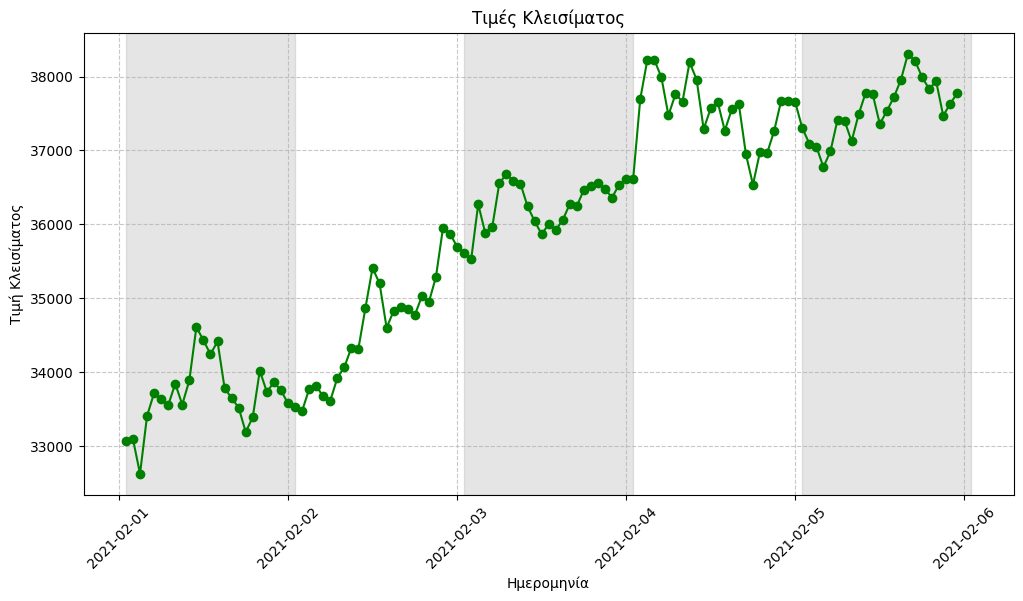

In [3]:
# Παράδειγμα χρήσης της νέας συνάρτησης για το διάστημα 1-5 Φεβρουαρίου 2021
start_date = '2021-02-01'
end_date = '2021-02-05'

# Απόκτηση δεδομένων τιμών μετοχών για το συγκεκριμένο διάστημα χωρίς δειγματοληψία
frequency = 60
stock_data_period_0 = get_stock_data_for_period(stock_df, start_date, end_date, frequency)
print("Πλήθος τιμών χωρίς δειγματοληψία:", stock_data_period_0.size/5)

# Σχεδίαση κατανομής και τιμών κλεισίματος για το δοσμένο διάστημα
# plot_records_distribution(stock_data_period_0)
plot_stock_prices(stock_data_period_0)

# Απόκτηση δεδομένων τιμών μετοχών για το συγκεκριμένο διάστημα με ανάλυση 235 λεπτών
# frequency = 235
# stock_data_period_235 = get_stock_data_for_period(stock_df, start_date, end_date, frequency)
# print("Πλήθος τιμών μετά από δειγματοληψία κάθε", frequency, "λεπτά:", stock_data_period_235.size/5)

# plot_stock_prices(stock_data_period_235)

## Test period

Πλήθος τιμών χωρίς δειγματοληψία: 119.0


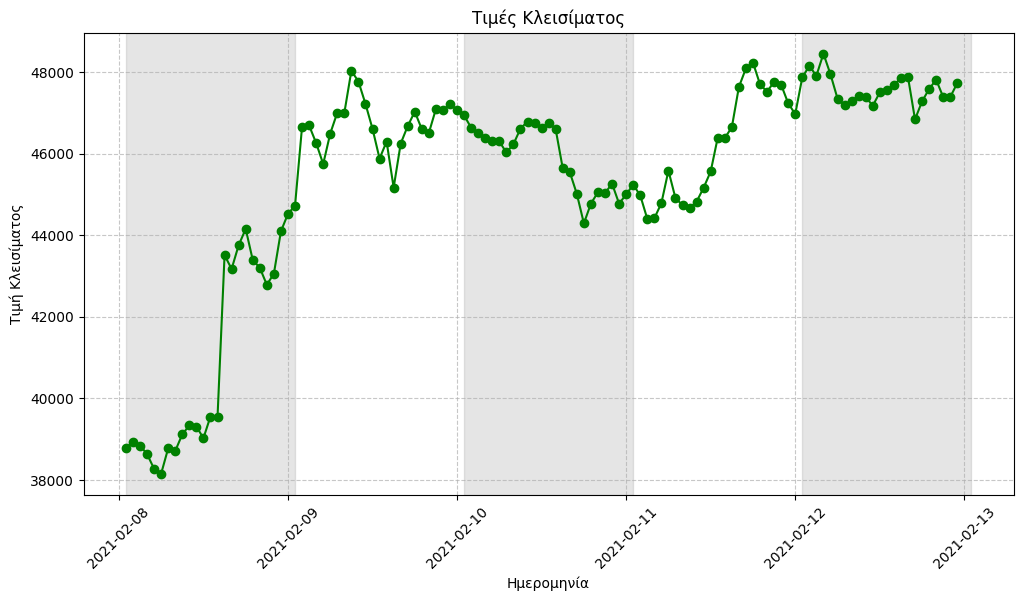

In [4]:
# Παράδειγμα χρήσης της νέας συνάρτησης για το διάστημα 8-12 Φεβρουαρίου 2021
start_date = '2021-02-08'
end_date = '2021-02-12'

# Απόκτηση δεδομένων τιμών μετοχών για το συγκεκριμένο διάστημα χωρίς δειγματοληψία
frequency = 60
stock_data_period_1 = get_stock_data_for_period(stock_df, start_date, end_date, frequency)
print("Πλήθος τιμών χωρίς δειγματοληψία:", stock_data_period_0.size/5)

# Σχεδίαση κατανομής και τιμών κλεισίματος για το δοσμένο διάστημα
# plot_records_distribution(stock_data_period_1)
plot_stock_prices(stock_data_period_1)

### RL Imports & Functions

In [5]:
### Imports
from tqdm import tqdm

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
# from gym_anytrading.envs import Actions
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 

from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

import torch

import quantstats as qs

from ta import add_all_ta_features

import matplotlib.pyplot as plt
import os
import pickle

import optuna

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING
def train_model(model, my_test_env, seed, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = my_test_env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    return

def my_render(env, df2=None, start_index=None, end_index=None, title=None):
    # Extract the price series for the episode
    prices = df2['Close'][0:end_index].values
    window_ticks = np.arange(len(prices))
    position_history = env._position_history
    window_size = env.window_size
    trade_fee = env.trade_fee if hasattr(env, 'trade_fee') else 0.0

    # Identify all trade points (count any position change as a trade)
    trade_ticks = []
    short_ticks = []
    long_ticks = []
    shorts = longs = 0
    # for i, tick in enumerate(window_ticks):
    for i, tick in enumerate(window_ticks):
        if env._position_history[i] == Positions.Short and env._position_history[i-1] != Positions.Short:
            trade_ticks.append(tick)
            short_ticks.append(tick)
            shorts+=1
        elif env._position_history[i] == Positions.Long and env._position_history[i-1] != Positions.Long:
            trade_ticks.append(tick)
            long_ticks.append(tick)
            longs+=1

    # Categorize trades as Good or Bad
    good_shorts = bad_shorts = good_longs = bad_longs = 0
    for i, tick in enumerate(trade_ticks):
        entry_price = prices[tick]
        if i < len(trade_ticks) - 1:
            exit_tick = trade_ticks[i + 1]
        else:
            exit_tick = len(prices) - 1
        exit_price = prices[exit_tick]
        position = position_history[tick]
        if position == Positions.Short:
            if exit_price < entry_price:
                good_shorts += 1
            else:
                bad_shorts += 1
        elif position == Positions.Long:
            if exit_price > entry_price:
                good_longs += 1
            else:
                bad_longs += 1

    # Manually calculate total_profit at each trade point
    total_profit = 1.0
    manual_profits = np.ones(len(prices))
    entry_price = None
    current_position = None

    for tick in range(len(prices)):
        if tick in trade_ticks:
            new_position = position_history[tick]
            current_price = prices[tick]
            if entry_price is not None and current_position is not None:
                if current_position == Positions.Long:
                    profit = current_price - entry_price - trade_fee
                    return_factor = 1 + profit / entry_price
                else:  # Short
                    profit = entry_price - current_price - trade_fee
                    return_factor = 1 + profit / entry_price
                total_profit *= return_factor
            entry_price = current_price
            current_position = new_position
        manual_profits[tick] = total_profit

    # Calculate RL model's net worth: total_profit * initial price
    initial_price = prices[0]
    rl_net_worth = manual_profits * initial_price

    # Determine the starting point for the RL net worth (first trade after window_size)
    start_idx = window_size
    if trade_ticks:
        first_trade = min(trade_ticks)
        if first_trade >= window_size:
            start_idx = first_trade

    # Create a step-like plot for RL net worth (update only at trade points)
    trade_ticks = [start_idx] + [tick for tick in trade_ticks if tick > start_idx]
    rl_steps_x = []
    rl_steps_y = []
    for i in range(len(trade_ticks)):
        current_tick = trade_ticks[i]
        if i < len(trade_ticks) - 1:
            next_tick = trade_ticks[i + 1]
        else:
            next_tick = len(prices)
        rl_steps_x.extend([current_tick, next_tick])
        rl_steps_y.extend([rl_net_worth[current_tick], rl_net_worth[current_tick]])

    # Calculate total returns
    buy_hold_return = prices[-1] / prices[0]
    rl_return = manual_profits[-1]

    # Plot the price series (Buy & Hold) and RL model's net worth
    plt.figure(figsize=(16, 6))
    plt.plot(window_ticks, prices, label=f"Buy & Hold (Return: {buy_hold_return:.2f})", color='blue')
    plt.plot(rl_steps_x, rl_steps_y, label=f"RL Model (Return: {rl_return:.2f})", color='orange', drawstyle='steps-post')

    # Plot Short and Long trades
    plt.plot(short_ticks, prices[short_ticks], 'rv', label='Short Trades')
    plt.plot(long_ticks, prices[long_ticks], 'g^', label='Long Trades')

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('Price / Net Worth')
    if title:
        plt.title(title)
    plt.suptitle(
        f"Total Reward: {env._total_reward:.6f} ~ " +
        f"Total Profit: {env._total_profit:.6f} ~ " +
        f"Total Trades: {shorts + longs} ~ " +
        f"Shorts: {shorts} ~ " +
        f"Longs: {longs}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the trade performance report
    print("Actual Decisions:")
    print(f"Good shorts: {good_shorts}, Bad shorts: {bad_shorts}")
    print(f"Good longs: {good_longs}, Bad longs: {bad_longs}")
    print(f"Total Actual Trades: {shorts + longs} ~ Shorts: {shorts} ~ Longs: {longs}")

    print("Calculated Total Profit:", manual_profits[-1])
    print("Environment Total Profit:", env._total_profit)

    # Generate quantstats reports using manual_profits
    qs.extend_pandas()
    # Create a pandas Series for net worth using manual_profits, indexed by dates
    net_worth = pd.Series(manual_profits, index=df2.index[0:end_index])
    # Calculate returns as percentage change, skipping the first NaN
    returns = net_worth.pct_change().iloc[1:]
    # Generate metrics report
    qs.reports.metrics(returns)
    # Generate snapshot plot
    qs.plots.snapshot(returns, mode='full', title='My Forex Trading Strategy', plot_all=False)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create train & test dfs - Train

In [6]:
env_name = 'forex-v0' # 'stocks-v0'

# df2 = add_all_ta_features(stock_data_period_0.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
# df3 = add_all_ta_features(stock_data_period_1.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df2 = stock_data_period_0.copy()
df3 = stock_data_period_1.copy()

window_size = 10
timesteps = 10 # K

trade_fee = 0.005 # <--- + - 0.005
seed = 42  # random seed
total_learning_timesteps = timesteps * 1000

start_index = window_size
end_index = len(df2)

def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    # signal_features = df2.loc[:, ['trend_macd_signal', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_signal', 'momentum_ppo_signal']].to_numpy()[start:end]
    signal_features = df2.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()[start:end]
    return prices, signal_features

class MyForexEnv(ForexEnv):
    _process_data = my_process_data


my_train_env = MyForexEnv(df=df2, window_size=window_size, frame_bound=(start_index, end_index))
my_train_env.trade_fee = trade_fee

my_train_env.window_size

seed = 42  # random seed

my_train_env.reset(seed=seed)

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class = PPO
policy_dict = model_class.policy_aliases
# https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
# MlpPolicy or MlpLstmPolicy
policy = policy_dict.get('MlpPolicy')
if policy is None:
    policy = policy_dict.get('MlpLstmPolicy')
# policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[400, 300])) # Off-Policy DDPG TD3 SAC TQC
# policy_kwargs = dict(net_arch=dict(pi=[64, 64], vf=[128, 128])) # On-policy PPO A2C TRPO
policy_kwargs = dict(net_arch=[64, 64])

try:
    model = model_class(policy, my_train_env, policy_kwargs=policy_kwargs, verbose=0)
    class_name = type(model).__qualname__
    train_model(model, my_train_env, seed, total_learning_timesteps)

except Exception as e:
    print(f"ERROR: {str(e)}")


--------------------------------------------------------------------------------


model.learn(): 10200it [00:11, 915.96it/s]                           


### Evaluation on train set

> max_possible_profit: 1.3625232450138987
Return: 0.9113108515441899
action_stats: {<Actions.Sell: 0>: 48, <Actions.Buy: 1>: 60}
info: {'total_reward': np.float64(-27257000.000000186), 'total_profit': np.float64(0.9113108515441899), 'position': <Positions.Short: 0>}
Decisions: 1 bad shorts,  46 neutral shorts,  0 good shorts,  19 bad longs,  30 neutral longs,  11 good longs... in total 107 trades
position_stats: shorts = 48 / longs =  60


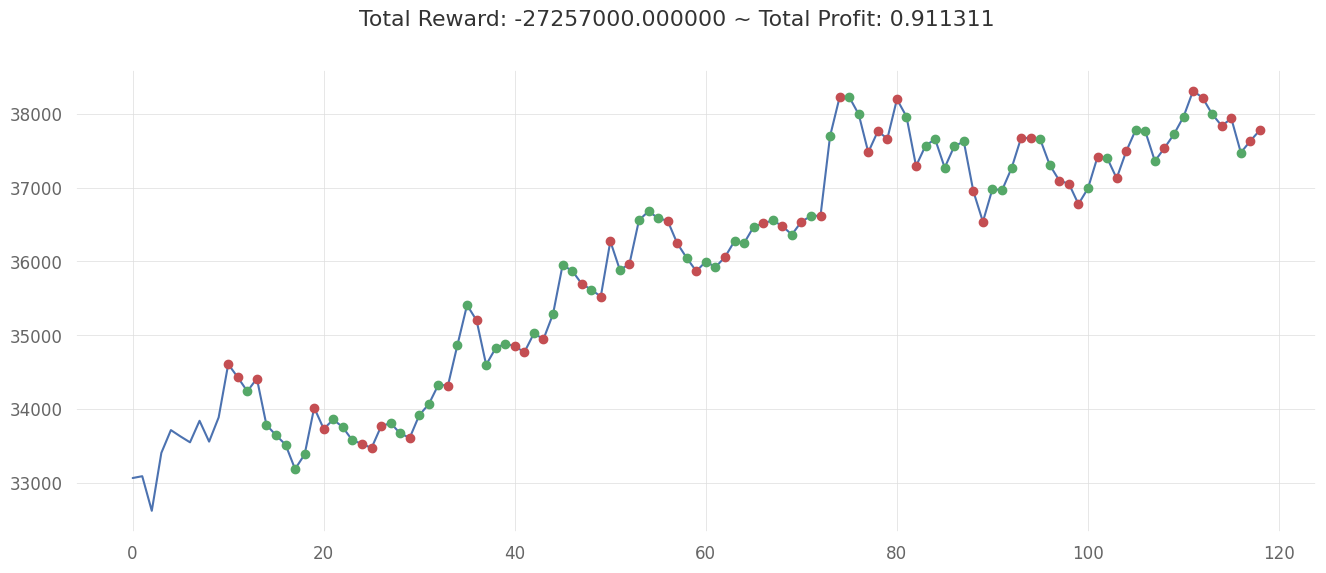

<Figure size 1600x600 with 0 Axes>

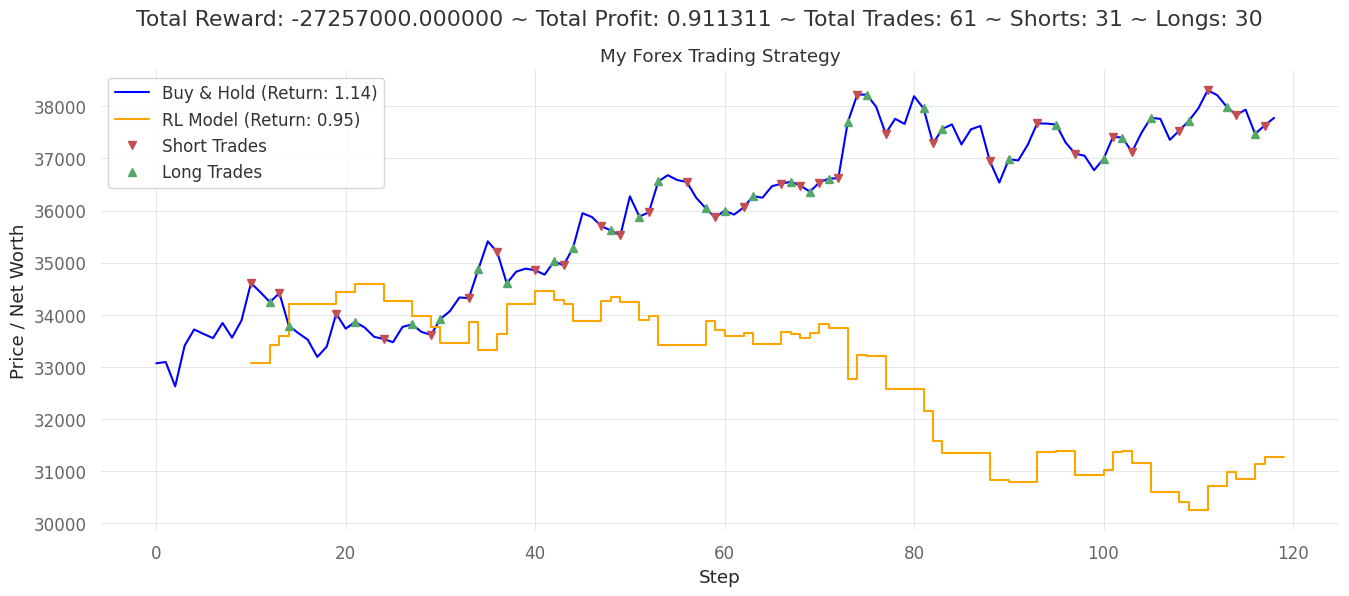

Actual Decisions:
Good shorts: 12, Bad shorts: 19
Good longs: 16, Bad longs: 14
Total Actual Trades: 61 ~ Shorts: 31 ~ Longs: 30
Calculated Total Profit: 0.945714316237644
Environment Total Profit: 0.9113108515441899


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


                    Strategy
------------------  ----------
Start Period        2021-02-01
End Period          2021-02-05
Risk-Free Rate      0.0%
Time in Market      51.0%

Cumulative Return   -5.43%
CAGR﹪              -97.03%

Sharpe              -0.95
Prob. Sharpe Ratio  25.54%
Sortino             -1.24
Sortino/√2          -0.87
Omega               0.81

Max Drawdown        -12.56%
Longest DD Days     4

Gain/Pain Ratio     -0.54
Gain/Pain (1M)      -1.0

Payoff Ratio        0.92
Profit Factor       0.81
Common Sense Ratio  0.61
CPC Index           0.35
Tail Ratio          0.75
Outlier Win Ratio   6.96
Outlier Loss Ratio  2.24

MTD                 -5.43%
3M                  -5.43%
6M                  -5.43%
YTD                 -5.43%
1Y                  -5.43%
3Y (ann.)           -97.03%
5Y (ann.)           -97.03%
10Y (ann.)          -97.03%
All-time (ann.)     -97.03%

Avg. Drawdown       -12.56%
Avg. Drawdown Days  4
Recovery Factor     0.42
Ulcer Index         0.06
Serenity Inde

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


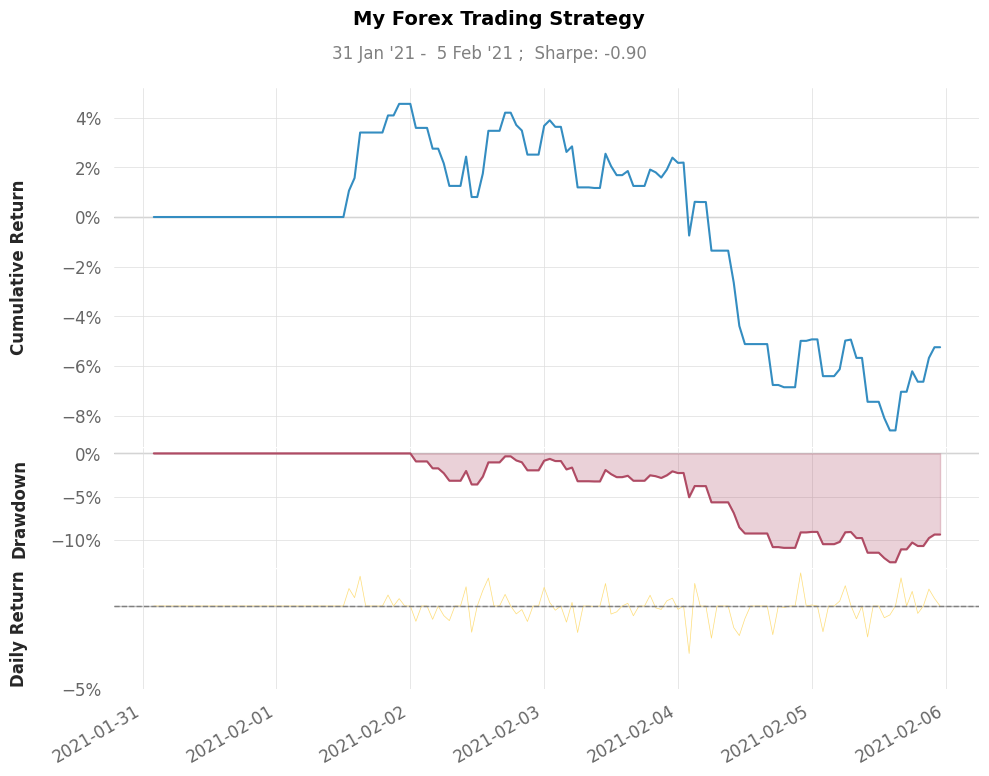

In [7]:
    
torch.manual_seed(seed)

action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = my_train_env.reset()

while True:
    action, _states = model.predict(observation, deterministic=False)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = my_train_env.step(action)
    done = terminated or truncated

    if done:
        break

profit_stats = pd.Series(my_train_env.unwrapped.history['total_profit'], index=stock_data_period_1.index[start_index+1:end_index])
reward_stats = pd.Series(my_train_env.unwrapped.history['total_reward'], index=stock_data_period_1.index[start_index+1:end_index])
position_stats = pd.Series(my_train_env.unwrapped.history['position'], index=stock_data_period_1.index[start_index+1:end_index])

my_train_env.close()
print("> max_possible_profit:", my_train_env.unwrapped.max_possible_profit())
print("Return:", profit_stats.iloc[-1])
print("action_stats:", action_stats)
print("info:", info)
badshort = goodshort = badlong = goodlong = neutshort = neutlong = 0
for i in range(1, len(reward_stats)):
    if profit_stats.iloc[i] < profit_stats.iloc[i-1]:
        if position_stats.iloc[i] == Positions.Short:
            badshort+=1
        elif position_stats.iloc[i] == Positions.Long:
            badlong+=1
    elif profit_stats.iloc[i] > profit_stats.iloc[i-1]:
        if position_stats.iloc[i] == Positions.Short:
            goodshort+=1
        elif position_stats.iloc[i] == Positions.Long:
            goodlong+=1
    else:
        if position_stats.iloc[i] == Positions.Short:
            neutshort+=1
        elif position_stats.iloc[i] == Positions.Long:
            neutlong+=1
print("Decisions:", badshort, "bad shorts, ", neutshort, "neutral shorts, ", goodshort, "good shorts, ", badlong, "bad longs, ", neutlong, "neutral longs, ", goodlong, "good longs... in total", badshort+goodshort+badlong+goodlong+neutshort+neutlong, "trades")
shorts = sum(1 for i in position_stats if i == Positions.Short)
longs = sum(1 for i in position_stats if i == Positions.Long)
print("position_stats: shorts =", shorts, "/ longs = ", longs)

plt.figure(figsize=(16, 6))
my_train_env.unwrapped.render_all()
plt.show()

plt.figure(figsize=(16, 6))
my_render(my_train_env, df2, start_index, end_index, title="My Forex Trading Strategy")
plt.show()

### Evaluation on test set

> max_possible_profit: 1.4673454933769727
Return: 0.8923192920611259
action_stats: {<Actions.Sell: 0>: 48, <Actions.Buy: 1>: 60}
info: {'total_reward': np.float64(-6759999.999999405), 'total_profit': np.float64(0.8923192920611259), 'position': <Positions.Short: 0>}
Decisions: 1 bad shorts,  46 neutral shorts,  0 good shorts,  15 bad longs,  30 neutral longs,  15 good longs... in total 107 trades
position_stats: shorts = 48 / longs =  60


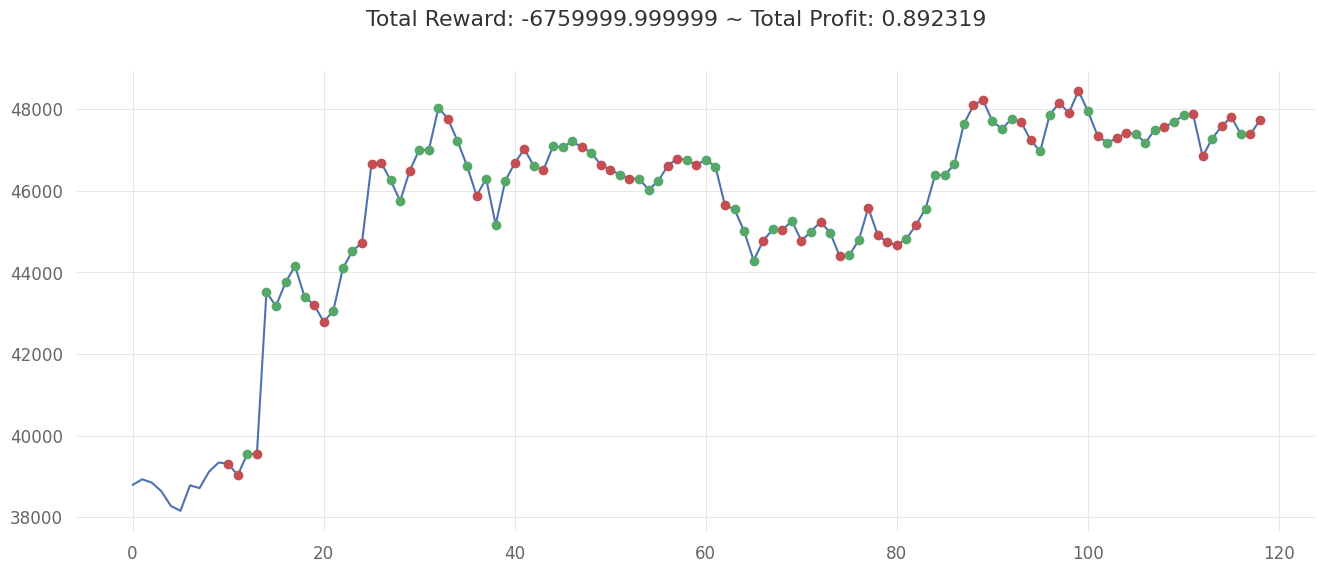

<Figure size 1600x600 with 0 Axes>

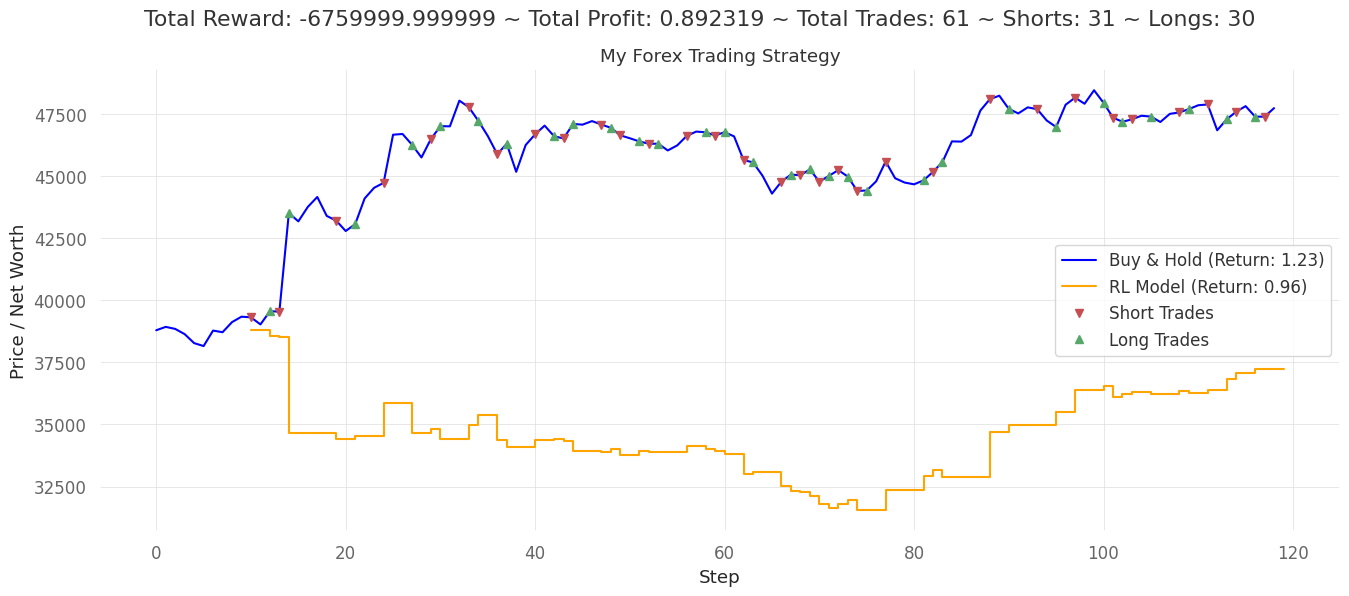

Actual Decisions:
Good shorts: 15, Bad shorts: 16
Good longs: 14, Bad longs: 16
Total Actual Trades: 61 ~ Shorts: 31 ~ Longs: 30
Calculated Total Profit: 0.9599673875588318
Environment Total Profit: 0.8923192920611259


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


                    Strategy
------------------  ----------
Start Period        2021-02-08
End Period          2021-02-12
Risk-Free Rate      0.0%
Time in Market      51.0%

Cumulative Return   -4.0%
CAGR﹪              -92.38%

Sharpe              -0.3
Prob. Sharpe Ratio  41.81%
Sortino             -0.37
Sortino/√2          -0.26
Omega               0.91

Max Drawdown        -18.67%
Longest DD Days     5

Gain/Pain Ratio     -0.16
Gain/Pain (1M)      -1.0

Payoff Ratio        0.97
Profit Factor       0.91
Common Sense Ratio  1.1
CPC Index           0.43
Tail Ratio          1.21
Outlier Win Ratio   10.33
Outlier Loss Ratio  3.06

MTD                 -4.0%
3M                  -4.0%
6M                  -4.0%
YTD                 -4.0%
1Y                  -4.0%
3Y (ann.)           -92.38%
5Y (ann.)           -92.38%
10Y (ann.)          -92.38%
All-time (ann.)     -92.38%

Avg. Drawdown       -18.67%
Avg. Drawdown Days  5
Recovery Factor     0.16
Ulcer Index         0.11
Serenity Index      

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


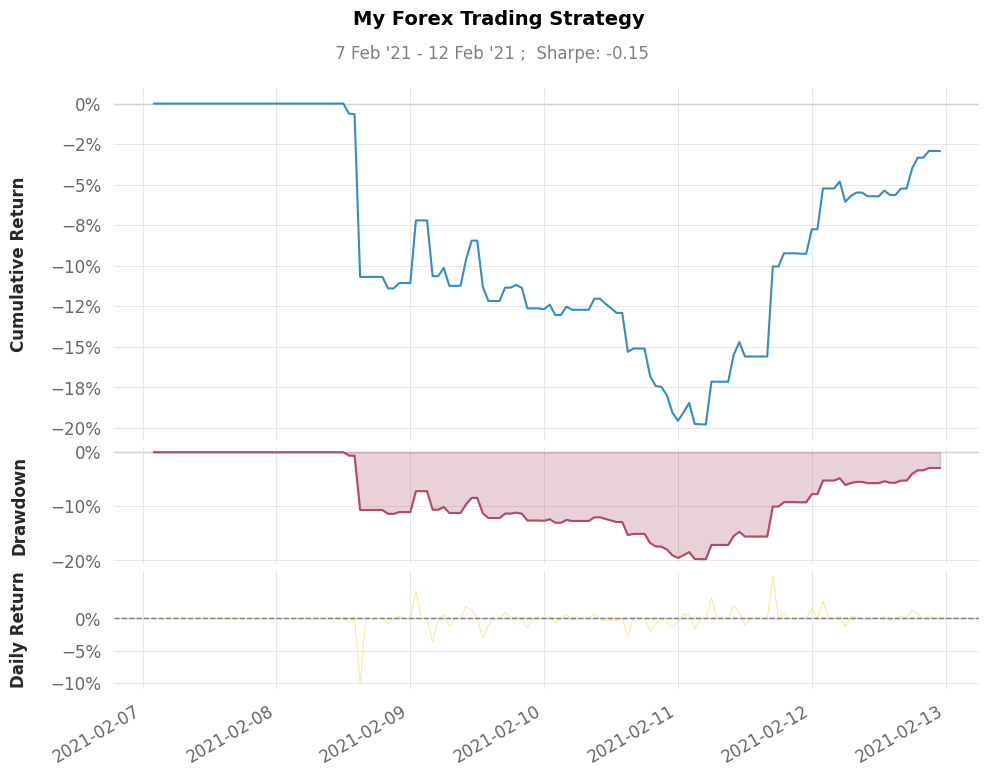

In [10]:
my_test_env = MyForexEnv(df=df3, window_size=window_size, frame_bound=(start_index, end_index))
start_index = window_size
end_index = len(df3)
my_test_env.trade_fee = trade_fee

torch.manual_seed(seed)

action_stats2 = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = my_test_env.reset()
# model = model.load('model_'+type(model).__qualname__+'_'+str(seed)+'_'+str(total_learning_timesteps) + '_' + str(window_size))

while True:
    action, _states = model.predict(observation, deterministic=False)

    action_stats2[Actions(action)] += 1
    observation, reward, terminated, truncated, info = my_test_env.step(action)
    done = terminated or truncated

    if done:
        break

profit_stats2 = pd.Series(my_test_env.unwrapped.history['total_profit'], index=stock_data_period_1.index[start_index+1:end_index])
reward_stats = pd.Series(my_test_env.unwrapped.history['total_reward'], index=stock_data_period_1.index[start_index+1:end_index])
position_stats = pd.Series(my_test_env.unwrapped.history['position'], index=stock_data_period_1.index[start_index+1:end_index])

my_test_env.close()
print("> max_possible_profit:", my_test_env.unwrapped.max_possible_profit())
print("Return:", profit_stats2.iloc[-1])
print("action_stats:", action_stats2)
print("info:", info)
badshort = goodshort = badlong = goodlong = neutshort = neutlong = 0
for i in range(1, len(reward_stats)):
    if profit_stats2.iloc[i] < profit_stats2.iloc[i-1]:
        if position_stats.iloc[i] == Positions.Short:
            badshort+=1
        elif position_stats.iloc[i] == Positions.Long:
            badlong+=1
    elif profit_stats2.iloc[i] > profit_stats2.iloc[i-1]:
        if position_stats.iloc[i] == Positions.Short:
            goodshort+=1
        elif position_stats.iloc[i] == Positions.Long:
            goodlong+=1
    else:
        if position_stats.iloc[i] == Positions.Short:
            neutshort+=1
        elif position_stats.iloc[i] == Positions.Long:
            neutlong+=1
print("Decisions:", badshort, "bad shorts, ", neutshort, "neutral shorts, ", goodshort, "good shorts, ", badlong, "bad longs, ", neutlong, "neutral longs, ", goodlong, "good longs... in total", badshort+goodshort+badlong+goodlong+neutshort+neutlong, "trades")
shorts = sum(1 for i in position_stats if i == Positions.Short)
longs = sum(1 for i in position_stats if i == Positions.Long)
print("position_stats: shorts =", shorts, "/ longs = ", longs)

plt.figure(figsize=(16, 6))
my_test_env.unwrapped.render_all()
plt.show()

plt.figure(figsize=(16, 6))
my_render(my_test_env, df3, start_index, end_index, title="My Forex Trading Strategy")
plt.show()